In [13]:
from os.path import dirname, join as pjoin
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import json
from pathlib import Path
import re

**Load label data from label studio json file.**

In [14]:
path = Path(f'..\data\\raw\\self-collected\\label-raw-data.json')

raw_json_file = open(path)
raw_json_data = json.load(raw_json_file)

In [16]:

def convert_to_pixels(result):
    '''
    Convert the result to pixels.
    Based of function in label studio manual export documentation.
    @param result: a dict containing keys 'original_width', 'original_height', and 'value'.
    @return [[x1, y1], [x2, y2], ...]
    '''
    if not ('original_width' in result or 'original_height' in result):
        return None
    value = result['value']
    w, h = result['original_width'], result['original_height']
    if not all([key in value for key in ['points', 'polygonlabels']]):
        return None
    points = value['points']
    pixels = []
    for point in points:
        pixels.append([w * point[0] / 100, h * point[1] / 100])
    return pixels


The first object in the ```raw_json_data``` list has three mask of two different labels. Two mast masks and one powerline mask.

In [17]:
mast1 = convert_to_pixels(raw_json_data[0]['annotations'][0]['result'][0])
mast1.append(mast1[0])
mast2 = convert_to_pixels(raw_json_data[0]['annotations'][0]['result'][1])
mast2.append(mast2[0])

powerline = convert_to_pixels(raw_json_data[0]['annotations'][0]['result'][2])
powerline.append(powerline[0])


Add all labels from json data into 1 figure.<br>
When ploting labels origin is in the upperleft instead of the classical lowerleft

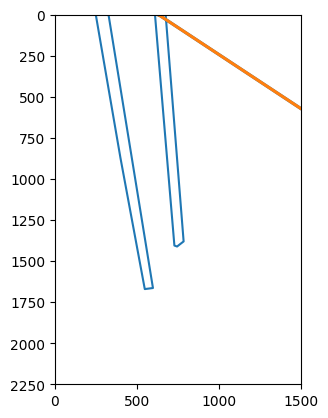

In [18]:
xs0, ys0 = zip(*mast1)
xs1, ys1 = zip(*mast2)
xs2, ys2 = zip(*powerline)
xs0, ys0  = xs0 + xs1 + xs2, ys0 + ys1 + ys2

plt.figure()
plt.plot(xs0, ys0)
plt.plot(xs2, ys2)
plt.xlim(0, raw_json_data[0]['annotations'][0]['result'][0]['original_width'])
plt.ylim(0, raw_json_data[0]['annotations'][0]['result'][0]['original_height'])
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

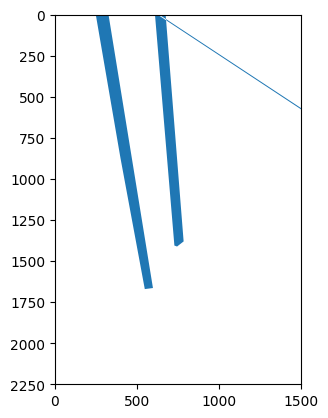

In [19]:
plt.fill(xs0, ys0)
plt.xlim(0, raw_json_data[0]['annotations'][0]['result'][0]['original_width'])
plt.ylim(0, raw_json_data[0]['annotations'][0]['result'][0]['original_height'])
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

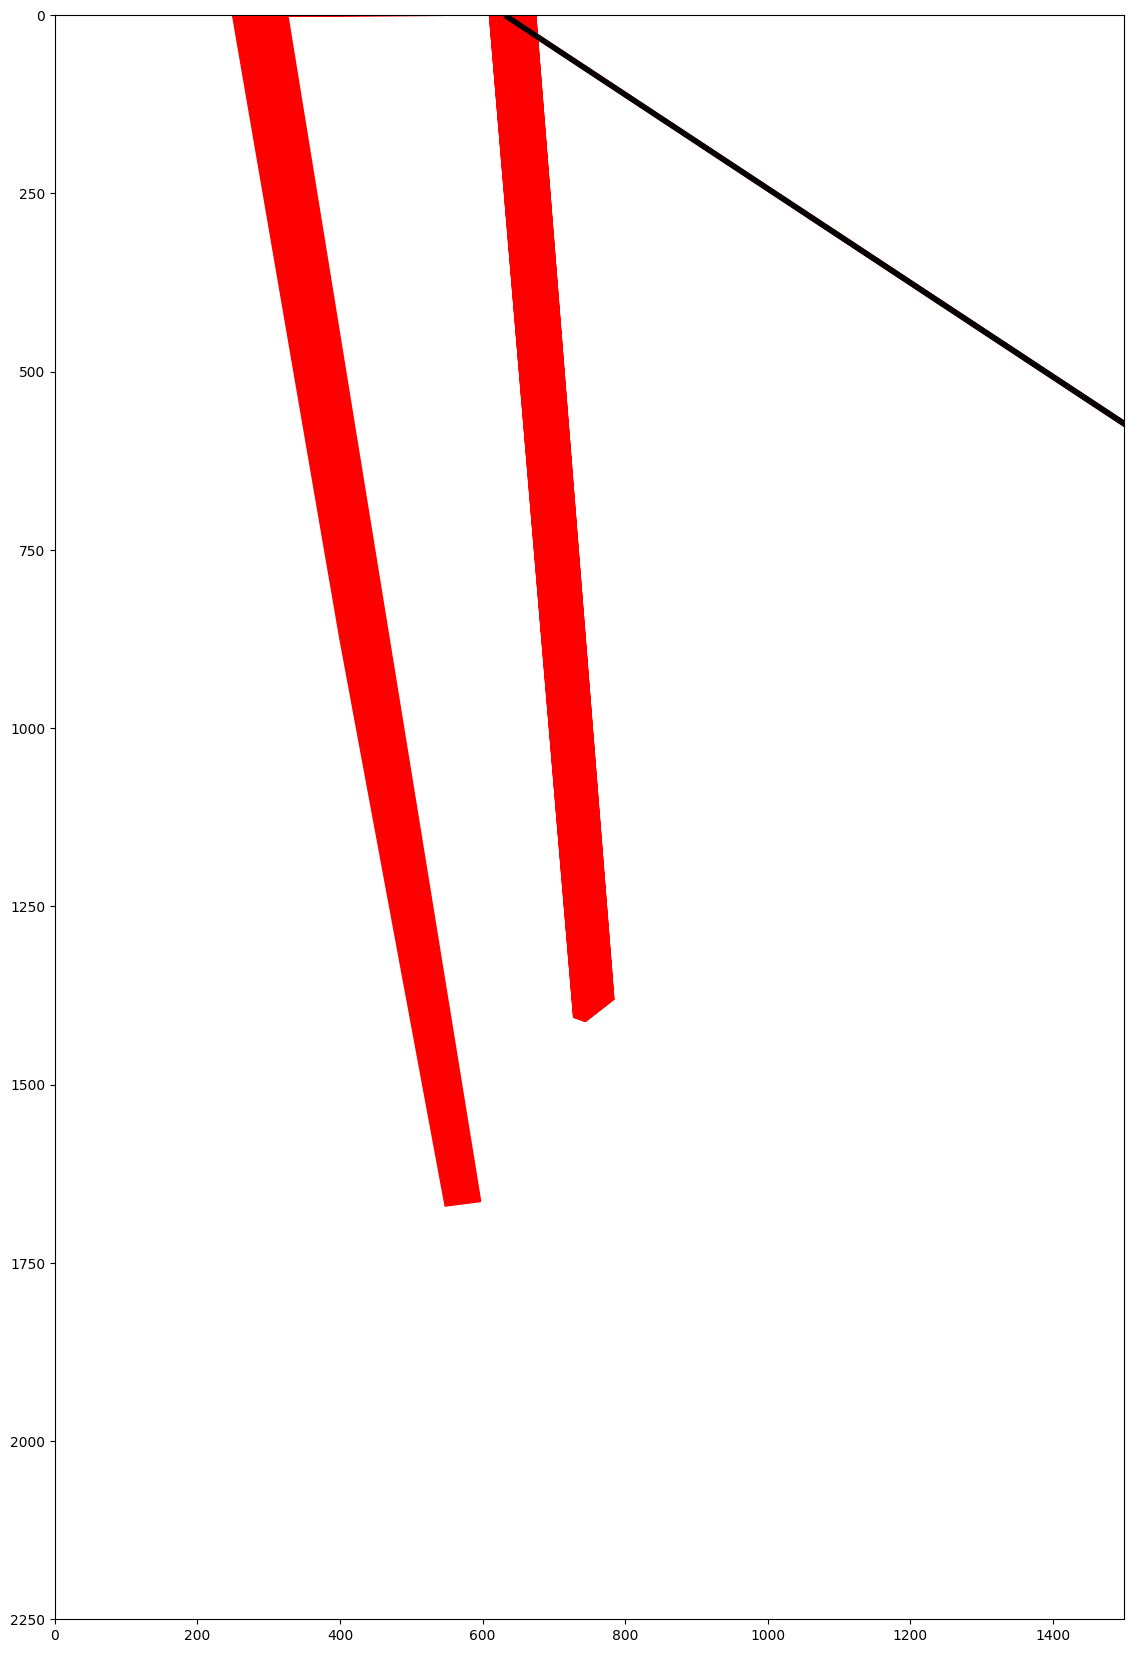

In [20]:
xm, ym = xs0 + xs1, ys0 + ys1
plt.figure(figsize=((2250/72), (1500/72)))
plt.fill(xm, ym, color='red')
plt.fill(xs2, ys2, color='black')
plt.xlim(0, raw_json_data[0]['annotations'][0]['result'][0]['original_width'])
plt.ylim(0, raw_json_data[0]['annotations'][0]['result'][0]['original_height'])
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

The image above is one of the few where the overlap. I made a mistake when labeling; I did not overlap the masks; and its going to cost me, fucking stupid mistakes man.

## **Creating masks from data**

I will create a mask for each label for each image.

The image above will have two masks, one for mast the other for powerlines.

In [209]:
def get_image_file_name(json_data):
    '''
    Get the file name of the image.
    @param json_data: label studio json data
    @return the original file name
    '''
    return re.search("[^-]*$", json_data['file_upload']).group(0)

def get_label(result):
    '''
    Get the label for each mask.
    @param json_data: label studio json data result object
    @return the label
    '''
    return result['value']['polygonlabels'][0]

def get_paths(label):
    '''
    Get the path to the folder for a given label.
    @param label: the label; one of these labels: 'mast', 'linje', 'topphette', 'trafo'
    @return: the path
    '''
    paths = {
        "mast": Path(f'O:\Dataingeniør Bachelor\\6. Semester\DAT255\course-project\data\interim\self-collected-labels\mast'),
        "linje": Path(f'O:\Dataingeniør Bachelor\\6. Semester\DAT255\course-project\data\interim\self-collected-labels\linje'),
        "topphette": Path(f'O:\Dataingeniør Bachelor\\6. Semester\DAT255\course-project\data\interim\self-collected-labels\\topphette'),
        "trafo": Path(f'O:\Dataingeniør Bachelor\\6. Semester\DAT255\course-project\data\interim\self-collected-labels\\trafo')
    }
    return paths.get(label)

def loop_over_json_annotation(image_data):
    '''
    Loop over all annotations in a label-studio json object.
    Creates a mask for each label in the json object and saves that mask in the path specified from the get_paths() function.
    @param image_data: label-studio json data object

    This has to be one of the least efficient functions i have ever written O(∞).
    Bear with me. Luckily n is quite small.
    '''
    
    label_dict = {'mast': [], 'linje': [], 'topphette': [], 'trafo': []}
    file_name = get_image_file_name(image_data)
    annotations = image_data['annotations']
    # Loop over each annotation and each result for each annotation, and add the polygon data to the label_dict.
    for annotation in annotations:
        results = annotation['result']
        for result in results: 
            label = get_label(result)
            
            points = convert_to_pixels(result)
            points.append(points[0])
            for key in label_dict.keys():
                if label in key:
                    label_dict[key].insert(-1, points)
            #xs, ys = zip(*points)
            #for xkey in x_dict.keys():
            #    if label in xkey:
            #        x_dict[xkey] = x_dict[xkey] + xs
            #for ykey in y_dict.keys():
            #    if label in ykey:
            #        y_dict[ykey] = y_dict[ykey] + ys
    # Loop over each key in the label_dict and create masks for each label then save them.
    for key in label_dict:
        label = key
        fig = plt.figure(frameon=False, figsize=(5, 7.5))
        # Label dict values are matrices. Inside each matrix is a list with coords to each polygon.
        for mask in label_dict[key]:
            x, y = zip(*mask)
            plt.fill(x,y, color='black')
        
        # Lots off commands to properly save the mask.
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.xlim(0, result['original_width'])
        plt.ylim(0, result['original_height'])
        plt.gca().set_aspect('equal')
        plt.gca().invert_yaxis()
        file_path = pjoin(get_paths(label), file_name)
        plt.savefig(file_path, edgecolor='none')
        plt.close(fig)
        
    #for x_key in x_dict.keys():
    #    label = x_key.split('_')[1]
    #    y_key = f'y_{label}'
    #    x_value = x_dict.get(x_key)
    #    y_value = y_dict.get(y_key)
    #    print(x_value)
    #    plt.ioff()
    #    fig = plt.figure(frameon=False, figsize=(5, 7.5))
    #    plt.fill(x_value, y_value, color='black')
    #    plt.gca().set_axis_off()
    #    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    #    plt.margins(0,0)
    #    plt.xlim(0, result['original_width'])
    #    plt.ylim(0, result['original_height'])
    #    plt.gca().set_aspect('equal')
    #    plt.gca().invert_yaxis()
#
    #    file_path = pjoin(get_paths(label), file_name)
    #    plt.savefig(file_path, edgecolor='none')
    #    plt.close(fig)

def loop_over_json_data(json_data: list):
    '''
    Loop over all the label-studio json data.
    @param json_data: label-tudio json data
    @return 
    '''
    for image in json_data:
        loop_over_json_annotation(image)
    

In [210]:
# plt.ioff()
# loop_over_json_data(raw_json_data)